# Figure 2: differential gene expression

## Load libraries

In [1]:
import numpy as np
import pandas as pd

import os

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
plt.rc('text', usetex=True)
plt.rcParams['text.latex.preamble'] = r'\boldmath \usepackage{amsmath} \usepackage{amssymb}'
from matplotlib.pyplot import cm

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, FixedLocator)

from sklearn.preprocessing import minmax_scale

import scipy

import itertools
from collections import Counter

from scipy.stats.stats import pearsonr, spearmanr
from scipy.stats import fisher_exact, hypergeom

import gc ## for garbage removal

## Load data

In [2]:
data_dir = '../data'

# rna-seq files #
rna_file = 'RNAseq-DEseq2-preprocessed-norm-counts.tsv'

# Mouse TFs database (downloaded from http://bioinfo.life.hust.edu.cn/AnimalTFDB/#!/download)
tf_database_file = '/home/andrew/biology/xdf/projects/utils/TF_lists/Mus_musculus_TF.txt'

In [3]:
## ---------------------  ##
## -- load RNAseq data -- ##
## ---------------------- ##
rna_df = pd.read_csv(data_dir+'/'+rna_file, sep='\t')

## take mean across replicates on each day ##
rna_df['day0'] = rna_df[['Day0_1','Day0_2','Day0_3']].mean(axis=1)
rna_df['day1'] = rna_df[['Day1_1','Day1_2','Day1_3']].mean(axis=1)
rna_df['day2'] = rna_df[['Day2_1','Day2_2','Day2_3']].mean(axis=1)
rna_df['day3'] = rna_df[['Day3_1','Day3_2','Day3_3']].mean(axis=1)
rna_df['day4-gfpneg'] = rna_df[['Day4_GFPneg_1','Day4_GFPneg_2','Day4_GFPneg_3']].mean(axis=1)
rna_df['day4-gfppos'] = rna_df[['Day4_GFPpos_1','Day4_GFPpos_2','Day4_GFPpos_3']].mean(axis=1)
rna_df['day5-gfpneg'] = rna_df[['Day5_GFPneg_1','Day5_GFPneg_2','Day5_GFPneg_3']].mean(axis=1)
rna_df['day5-gfppos'] = rna_df[['Day5_GFPpos_1','Day5_GFPpos_2','Day5_GFPpos_3']].mean(axis=1)

print(rna_df.columns, rna_df.shape)

Index(['Unnamed: 0', 'ext_gene', 'ens_gene', 'chrom', 'chromStart', 'chromEnd',
       'strand', 'Day0_1', 'Day0_2', 'Day0_3', 'Day1_1', 'Day1_2', 'Day1_3',
       'Day2_1', 'Day2_2', 'Day2_3', 'Day3_1', 'Day3_2', 'Day3_3',
       'Day4_GFPneg_1', 'Day4_GFPneg_2', 'Day4_GFPneg_3', 'Day4_GFPpos_1',
       'Day4_GFPpos_2', 'Day4_GFPpos_3', 'Day5_GFPneg_1', 'Day5_GFPneg_2',
       'Day5_GFPneg_3', 'Day5_GFPpos_1', 'Day5_GFPpos_2', 'Day5_GFPpos_3',
       'EF-up', 'EF-down', 'D0-D1-up', 'D0-D1-down', 'D1-D2-up', 'D1-D2-down',
       'D2-D3-up', 'D2-D3-down', 'HK', 'tad-id-bonev', 'day0', 'day1', 'day2',
       'day3', 'day4-gfpneg', 'day4-gfppos', 'day5-gfpneg', 'day5-gfppos'],
      dtype='object') (49705, 49)


In [4]:
## load Mus musculus TF list
tf_list_df = pd.read_csv(tf_database_file,sep='\t')
tf_list = tf_list_df['Symbol'].tolist()
print(len(tf_list))

ef_up_tfs   = rna_df['ext_gene'][rna_df['ext_gene'].isin(tf_list) & rna_df['EF-up']].tolist()
ef_down_tfs = rna_df['ext_gene'][rna_df['ext_gene'].isin(tf_list) & rna_df['EF-down']].tolist()

## number of up and down-regulated genes that are TFs ##
print('EF up TFs:  ', len(ef_up_tfs), 'of', rna_df['EF-up'].sum())
print('EF down TFs:', len(ef_down_tfs), 'of', rna_df['EF-down'].sum())

print()
d2d3_up_tfs   = rna_df['ext_gene'][rna_df['ext_gene'].isin(tf_list) & rna_df['D2-D3-up']].tolist()
d2d3_down_tfs = rna_df['ext_gene'][rna_df['ext_gene'].isin(tf_list) & rna_df['D2-D3-down']].tolist()

print(sorted(rna_df['ext_gene'][rna_df['ext_gene'].isin(tf_list) & rna_df['D2-D3-up']].tolist()))
print(sorted(rna_df['ext_gene'][rna_df['ext_gene'].isin(tf_list) & rna_df['D2-D3-down']].tolist()))

print('D2-D3-up TFs:  ', len(d2d3_up_tfs), 'of', rna_df['D2-D3-up'].sum())
print('D2-D3-down TFs:', len(d2d3_down_tfs), 'of', rna_df['D2-D3-down'].sum())
print()
print(sorted(list(set(set(d2d3_up_tfs) & set(ef_up_tfs)))))
print(sorted(list(set(set(d2d3_up_tfs) & set(ef_down_tfs)))))
print(sorted(list(set(set(d2d3_down_tfs) & set(ef_up_tfs)))))
print(sorted(list(set(set(d2d3_down_tfs) & set(ef_down_tfs)))))

1636
EF up TFs:   11 of 37
EF down TFs: 65 of 453

['Crx', 'Evx1', 'Fezf1', 'Fezf2', 'Foxb1', 'Foxd4', 'Gsc', 'Hesx1', 'Irx3', 'Irx5', 'Lhx1', 'Lhx2', 'Lhx5', 'Lmx1b', 'Mesp1', 'Mixl1', 'Neurog2', 'Pax2', 'Pknox2', 'Prox1', 'Rax', 'Sall3', 'Six3', 'Sox9', 'Sp5', 'Sp8', 'T', 'Zeb2', 'Zfhx4', 'Zfp521', 'Zfp935']
['Etv4', 'Gm4969', 'Parp12', 'Pax8', 'Rhox1', 'Six1', 'Sohlh1', 'Tal1', 'Tcf15', 'Wt1']
D2-D3-up TFs:   31 of 165
D2-D3-down TFs: 10 of 85

['Fezf1', 'Lhx2', 'Rax', 'Six3']
['Gsc', 'Irx3', 'Lmx1b', 'Mixl1', 'T']
[]
['Etv4', 'Tcf15']


In [5]:
efup_genes   = rna_df['ext_gene'][rna_df['EF-up']].tolist()
efdown_genes = rna_df['ext_gene'][rna_df['EF-down']].tolist()

d2d3_up_genes   = rna_df['ext_gene'][rna_df['D2-D3-up']].tolist()
d2d3_down_genes = rna_df['ext_gene'][rna_df['D2-D3-down']].tolist()

print(sorted(list(set(d2d3_up_genes) & set(efup_genes))))
print(sorted(list(set(d2d3_up_genes) & set(efdown_genes))))
print(sorted(list(set(d2d3_down_genes) & set(efup_genes))))
print(sorted(list(set(d2d3_down_genes) & set(efdown_genes))))

['Ermn', 'Fezf1', 'Grem1', 'Lhx2', 'Ptprz1', 'Rax', 'Shisa2', 'Six3', 'Six3os1']
['C130021I20Rik', 'Cer1', 'Fgf8', 'Frmpd2', 'Gsc', 'Irx3', 'Lmx1b', 'Mixl1', 'Rpl38-ps2', 'T', 'Wnt3', 'Wnt8a']
[]
['Calml4', 'Dppa4', 'Etv4', 'Fam25c', 'Gpx2', 'Grm6', 'Gstp2', 'Lefty1', 'Lefty2', 'Morc1', 'Notum', 'Nupr1', 'P2rx7', 'Rpl10l', 'Tcf15', 'Tmem40', 'Zp3']


## EFup TFs, Xenopus TFs, EF-related heatmap 

In [6]:
rna_days = ['day0', 'day1', 'day2', 'day3', 'day4-gfpneg', 'day4-gfppos', 'day5-gfpneg', 'day5-gfppos']

ef_TFs_xenopus = [ 'Six3', 'Rax', 'Lhx2', 'Pax6', 'Six6', 'Tbx3', 'Nr2e1' ]

ef_TFs_other = rna_df['ext_gene'][rna_df['EF-up'] & rna_df['ext_gene'].isin(tf_list)].tolist()
ef_TFs_other = [gene for gene in ef_TFs_other if gene not in ef_TFs_xenopus]

ef_genes_putative = rna_df['ext_gene'][rna_df['EF-up'] & (~rna_df['ext_gene'].isin(tf_list))].tolist()

ef_genes_related = [ 'Otx2', 'Sox2', 'Zic2' ]

print(ef_TFs_xenopus)
print(ef_TFs_other, len(ef_TFs_other))
print(ef_genes_putative, len(ef_genes_putative))
print(ef_genes_related)

ef_TFs_xenopus_expression = []
for gene in ef_TFs_xenopus: 
    ef_TFs_xenopus_expression.append(rna_df[rna_days][rna_df['ext_gene']==gene].values[0].tolist())    
ef_TFs_xenopus_expression = np.array(ef_TFs_xenopus_expression)

ef_TFs_other_expression = []
for gene in ef_TFs_other: 
    ef_TFs_other_expression.append(rna_df[rna_days][rna_df['ext_gene']==gene].values[0].tolist())    
ef_TFs_other_expression = np.array(ef_TFs_other_expression)

ef_genes_putative_expression = []
for gene in ef_genes_putative: 
    ef_genes_putative_expression.append(rna_df[rna_days][rna_df['ext_gene']==gene].values[0].tolist())    
ef_genes_putative_expression = np.array(ef_genes_putative_expression)

ef_genes_related_expression = []
for gene in ef_genes_related: 
    ef_genes_related_expression.append(rna_df[rna_days][rna_df['ext_gene']==gene].values[0].tolist())    
ef_genes_related_expression = np.array(ef_genes_related_expression)

['Six3', 'Rax', 'Lhx2', 'Pax6', 'Six6', 'Tbx3', 'Nr2e1']
['Vax1', 'Foxg1', 'Fezf1', 'Maf', 'Arid3c', 'Gbx1'] 6
['Efnb2', 'Phlda1', 'Edn1', 'Vit', 'Igfbp5', 'Ermn', 'Lmo3', 'Necab2', 'Slc38a8', 'Pcdh17', 'Tmtc2', 'Shisa2', 'Fzd1', 'Nxph1', 'Minar2', 'Mab21l1', 'Nlgn1', 'Ptprz1', 'Grem1', 'Slc8a3', 'BC064078', 'Gm13584', 'Six3os1', 'Gm26709', 'Raxos1', 'Gm27197'] 26
['Otx2', 'Sox2', 'Zic2']


14.875153300531535 14.131964081604108
0.5426811594202898
0.05203260869565217
02_rna-seq-heatmap-canonical-plus-other-EF-genes.pdf


/home/andrew/bin/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/andrew/bin/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


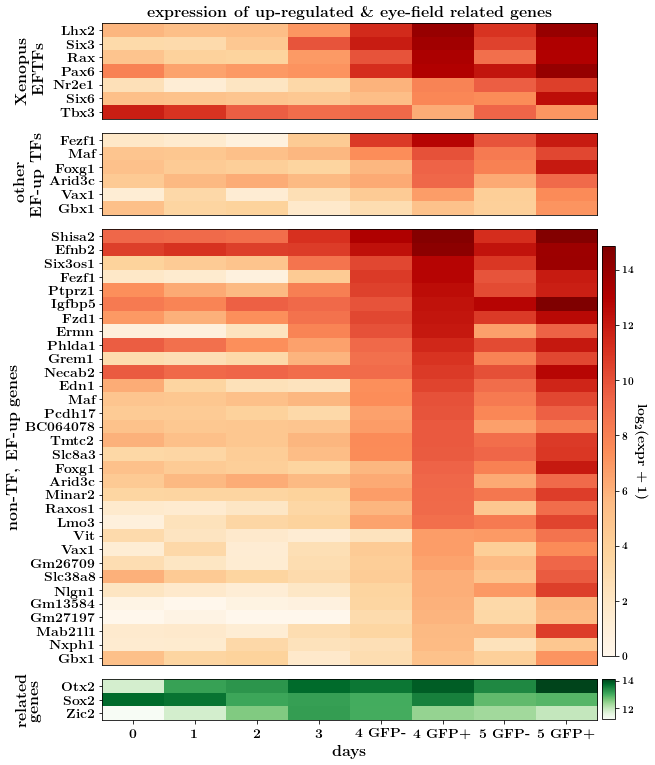

In [20]:
## plot of EF expression ##

days_labels = ['x', r'\bf 0', r'\bf 1', r'\bf 2', r'\bf 3', 
               r'\bf 4 GFP-', r'\bf 4 GFP+', r'\bf 5 GFP-', r'\bf 5 GFP+']

aspect_ratio = 0.15 * ef_TFs_xenopus_expression.shape[1] / ef_TFs_xenopus_expression.shape[0]
aspect_ratio = 0.22

## make plot ##
fig, axs = plt.subplots(4, 1, figsize=(12,10.5), 
                        gridspec_kw={'height_ratios':[ef_TFs_xenopus_expression.shape[0],
                                                      ef_TFs_other_expression.shape[0],
                                                      ef_genes_putative_expression.shape[0],
                                                      ef_genes_related_expression.shape[0],
                                                     ]})
axs = axs.ravel()

vmax = max([np.max(np.log2(ef_TFs_xenopus_expression+1)),
            np.max(np.log2(ef_TFs_other_expression+1)),
            np.max(np.log2(ef_genes_putative_expression+1))])
vmax2 = np.max(np.log2(ef_genes_related_expression+1))
print(vmax, vmax2)

plt_idx = np.argsort(ef_TFs_xenopus_expression[:,5])[::-1]
im0 = axs[0].imshow(np.log2(ef_TFs_xenopus_expression+1)[plt_idx], 
                    interpolation='nearest', vmin=0, vmax=vmax, cmap='OrRd',aspect=aspect_ratio)
axs[0].set_yticks(list(range(ef_TFs_xenopus_expression.shape[0])))
axs[0].set_yticklabels([r'\bf '+gene for gene in np.array(ef_TFs_xenopus)[plt_idx]],fontsize=14)

plt_idx = np.argsort(ef_TFs_other_expression[:,5])[::-1]
im1 = axs[1].imshow(np.log2(ef_TFs_other_expression+1)[plt_idx], 
                    interpolation='nearest', vmin=0, vmax=vmax, cmap='OrRd',aspect=aspect_ratio)
axs[1].set_yticks(list(range(ef_TFs_other_expression.shape[0])))
axs[1].set_yticklabels([r'\bf '+gene for gene in np.array(ef_TFs_other)[plt_idx]],fontsize=14)

plt_idx = np.argsort(ef_genes_putative_expression[:,5])[::-1]
im2 = axs[2].imshow(np.log2(ef_genes_putative_expression+1)[plt_idx], 
                    interpolation='nearest', vmin=0, vmax=vmax, cmap='OrRd',aspect=aspect_ratio)
axs[2].set_yticks(list(range(ef_genes_putative_expression.shape[0])))
axs[2].set_yticklabels([r'\bf '+gene for gene in np.array(ef_genes_putative)[plt_idx]],fontsize=14)


plt_idx = np.argsort(ef_genes_related_expression[:,5])[::-1]
im3 = axs[3].imshow(np.log2(ef_genes_related_expression+1)[plt_idx], 
                    interpolation='nearest', vmax=vmax2, cmap='Greens',aspect=aspect_ratio)
axs[3].set_yticks(list(range(ef_genes_related_expression.shape[0])))
axs[3].set_yticklabels([r'\bf '+gene for gene in np.array(ef_genes_related)[plt_idx]],fontsize=14)


axs[0].set_xticks([])
axs[1].set_xticks([])
axs[2].set_xticks([])
axs[3].set_xticklabels(days_labels,fontsize=14)
axs[3].set_xlabel(r'\bf days',fontsize=16)

axs[0].set_ylabel(r'\bf Xenopus \\[2pt] \phantom{ba}  EFTFs',fontsize=16,labelpad=10)
axs[1].set_ylabel(r'\bf other \\[5pt] EF-up TFs',fontsize=16)
axs[2].set_ylabel(r'\bf non-TF, EF-up genes',fontsize=16)
axs[3].set_ylabel(r'\bf related \\ \phantom{al} genes',fontsize=16,labelpad=20)

## first colorbar ##
cbar_height = axs[2].get_position().height+0.105
cax = fig.add_axes([axs[2].get_position().x1+.062,
                    axs[2].get_position().y0-0.050,0.015,
                    cbar_height])
print(cbar_height)
cbar = plt.colorbar(im2, cax=cax) # Similar to fig.colorbar(im, cax = cax)
cbar.set_label(r'\bf $\log_2({\rm expr} + 1)$', rotation=270, fontsize=14, labelpad=15)

## second colorbar ##
cbar_height = axs[3].get_position().height+0.011
cax2 = fig.add_axes([axs[3].get_position().x1+.062,
                    axs[3].get_position().y0-0.059,0.015,
                    cbar_height])
print(cbar_height)
cbar = plt.colorbar(im3, cax=cax2) # Similar to fig.colorbar(im, cax = cax)

plt.tight_layout()
axs[0].set_title(r'\bf expression of up-regulated \& eye-field related genes',fontsize=16)
plt_str = '02_rna-seq-heatmap-canonical-plus-other-EF-genes.pdf'
print(plt_str)
#plt.savefig('./figures_paper/'+plt_str,bbox_inches='tight')
plt.show()

## EF up and down heatmaps

In [8]:
rna_days = ['day0', 'day1', 'day2', 'day3', 'day4-gfpneg', 'day4-gfppos', 'day5-gfpneg', 'day5-gfppos']

ef_genes_standard = [ 'Six3', 'Rax', 'Lhx2', 'Pax6', 'Six6' ]
ef_genes_putative = rna_df['ext_gene'][rna_df['EF-up']].tolist()
ef_genes_putative = [gene for gene in ef_genes_putative if gene not in ef_genes_standard]
#
ef_genes_other = [ 'Nr2e1', 'Tbx3', 'Otx2', 'Sox2', 'Zic2' ]

ef_genes_down = rna_df['ext_gene'][rna_df['EF-down']].tolist()

ef_genes_standard_expression = []
for gene in ef_genes_standard: 
    ef_genes_standard_expression.append(rna_df[rna_days][rna_df['ext_gene']==gene].values[0].tolist())    
ef_genes_standard_expression = np.array(ef_genes_standard_expression)

ef_genes_putative_expression = []
for gene in ef_genes_putative: 
    ef_genes_putative_expression.append(rna_df[rna_days][rna_df['ext_gene']==gene].values[0].tolist())    
ef_genes_putative_expression = np.array(ef_genes_putative_expression)

ef_genes_other_expression = []
for gene in ef_genes_other: 
    ef_genes_other_expression.append(rna_df[rna_days][rna_df['ext_gene']==gene].values[0].tolist())    
ef_genes_other_expression = np.array(ef_genes_other_expression)

ef_genes_down_expression = []
for gene in ef_genes_down: 
    ef_genes_down_expression.append(rna_df[rna_days][rna_df['ext_gene']==gene].values[0].tolist())    
ef_genes_down_expression = np.array(ef_genes_down_expression)

/home/andrew/bin/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/andrew/bin/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


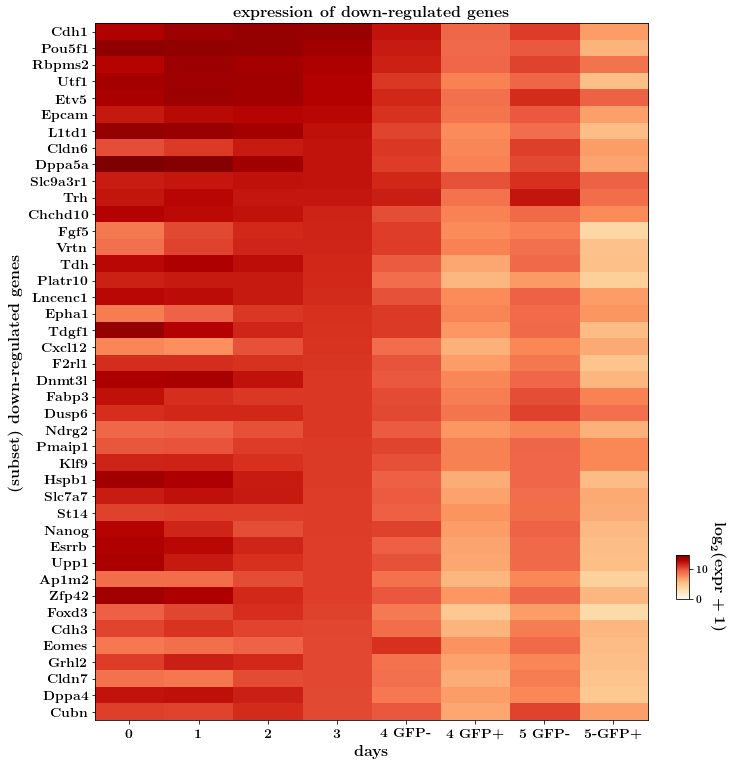

In [9]:
## plot of EF down expression ##
## note only plot subset of genes, as there are many

n_plt_genes = len(ef_genes_standard_expression) \
            + len(ef_genes_putative_expression) + len(ef_genes_other_expression)
n_plt_idx = np.argsort(ef_genes_down_expression[:,3])[::-1][:n_plt_genes]

days_labels = ['x', r'\bf 0', r'\bf 1', r'\bf 2', r'\bf 3', 
               r'\bf 4 GFP-', r'\bf 4 GFP+', r'\bf 5 GFP-', r'\bf 5-GFP+']

aspect_ratio = 0.15 * ef_genes_standard_expression.shape[1] / ef_genes_standard_expression.shape[0]

## make plot ##
fig, axs = plt.subplots(1, 1, figsize=(12,10.5))
# axs = axs.ravel()

vmax = np.max(np.log2(ef_genes_down_expression+1))

im0 = axs.imshow(np.log2(ef_genes_down_expression+1)[n_plt_idx], 
                    interpolation='nearest', vmin=0, vmax=vmax, cmap='OrRd',aspect=aspect_ratio)

axs.set_yticks(list(range(n_plt_genes)))
axs.set_yticklabels([r'\bf '+gene for gene in np.array(ef_genes_down)[n_plt_idx]],fontsize=14)

axs.set_xticklabels(days_labels,fontsize=14)
axs.set_xlabel(r'\bf days',fontsize=16)

axs.set_ylabel(r'\bf (subset) down-regulated genes',fontsize=16,labelpad=5)

cax = fig.add_axes([axs.get_position().x1+.078,
                    axs.get_position().y0+0.10,0.015,
                    cbar_height])
cbar = plt.colorbar(im1, cax=cax) # Similar to fig.colorbar(im, cax = cax)
cbar.set_label(r'\bf $\log_2({\rm expr} + 1)$', rotation=270, fontsize=16, labelpad=19)


plt.tight_layout()


axs.set_title(r'\bf expression of down-regulated genes',fontsize=16)
#plt_str = '00_rna-seq-heatmap-EF-down-genes.pdf'
#print(plt_str)
#plt.savefig('./figures_paper/'+plt_str,bbox_inches='tight')
plt.show()

## Clustering of gene expression

In [10]:
from sklearn.mixture import GaussianMixture
import ClusterEnsembles as CE

In [11]:
bool_genes_select = rna_df['EF-up'] | rna_df['EF-down']
###
rna_select_df = rna_df[bool_genes_select]
rna_select_days = ['day0', 'day1', 'day2', 'day3', 'day4-gfppos', 'day5-gfppos']
rna_select_expr = rna_select_df[rna_select_days].values
rna_select_genes = rna_select_df['ext_gene'].tolist()

## log transform ##
rna_select_expr = np.log2(rna_select_expr + 1)
## log transform ##

rna_select_expr = np.roll(rna_select_expr,-4,axis=0)
rna_select_genes = list(np.roll(np.array(rna_select_genes),-4))

# z-transform 
rna_select_expr_zvals = (rna_select_expr.T - rna_select_expr.mean(axis=1))/rna_select_expr.std(axis=1)
rna_select_expr_zvals = rna_select_expr_zvals.T

print(rna_select_expr_zvals.shape)

(490, 6)


In [12]:
genes_of_interest = ['Rax','Lhx2','Six3', 'Fezf1',
                     'Pax6', 'Six6','Mab21l1',
                     'Pou5f1','Nanog','Klf4',
                     'Dppa5a','Neurod1','Etv5','Zfp42','Tbx3','Foxd3',
                     'Cdh1','Esrrb',
                     'Wnt3', 'Wnt8a','Fgf8','Lmx1b',
                     'En2']
genes_of_interest_idx = [rna_select_genes.index(gene) for gene in genes_of_interest]
print(genes_of_interest_idx)

[115, 487, 271, 185, 152, 71, 361, 112, 43, 14, 366, 238, 44, 345, 51, 386, 488, 72, 486, 42, 125, 269, 272]


In [13]:
############################################
## -- cluster using consensus approach -- ##
############################################

gm_params = {
    'tol':5e-5,
    'max_iter':10000,
    'n_init':100
}

random_seeds = list(np.random.randint(0,high=10000,size=20))
print(random_seeds)

bic_vals = []
aic_vals = []
ll_vals  = []

ncpts_list = [3,4,5,6,7,8,9]
nclust_bic_scores = []
for ncpts in ncpts_list :
    
    tmp_bic_list = []
    for seed in random_seeds:
        #print(seed)
        #print('Fitting GM for', ncpts, 'components')
        gm = GaussianMixture(n_components=ncpts, 
                             random_state=seed, **gm_params).fit(rna_select_expr_zvals)
        tmp_bic = gm.bic(rna_select_expr_zvals)
        tmp_bic_list.append(tmp_bic)
        del gm
    nclust_bic_scores.append(tmp_bic_list)
    gc.collect()
    print('GM for', ncpts, 'components',
              f'{np.mean(tmp_bic_list):.3f}', f'{np.median(tmp_bic_list):.3f}')

[4728, 13, 5645, 5413, 1451, 2746, 9221, 2689, 3700, 3108, 8449, 6273, 9507, 3137, 2584, 1938, 9717, 1866, 7419, 1860]
GM for 3 components -5252.879 -5252.879
GM for 4 components -5634.957 -5634.957
GM for 5 components -5851.929 -5851.929
GM for 6 components -5894.631 -5906.049
GM for 7 components -5867.913 -5880.122
GM for 8 components -5805.861 -5805.475
GM for 9 components -5719.027 -5716.392


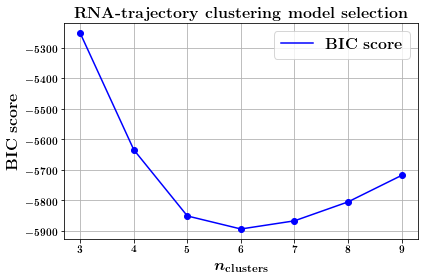

In [14]:
plt.plot(ncpts_list, np.array(nclust_bic_scores).mean(axis=1),color='Blue',label=r'\bf BIC score')
plt.plot(ncpts_list, np.array(nclust_bic_scores).mean(axis=1),'o',color='Blue')
plt.legend(fontsize=16)
plt.xlabel(r'\bf $n_{\text{clusters}}$',fontsize=16)
plt.ylabel(r'\bf BIC score',fontsize=16)
plt.title(r'\bf RNA-trajectory clustering model selection',fontsize=16)
plt.grid()

plt.tight_layout()
file_str = '01_rna_clustering_GMM_BIC_scores_multiple_runs.pdf'
#plt.savefig('./figures_paper/'+file_str)
plt.show()

In [15]:
## now run final clustering for "best" number of components ##
gm_params = {
    'tol':5e-5,
    'max_iter':10000,
    'n_init':100
}


ncpts_best = 6
np.random.seed(42)
random_seeds = list(np.random.randint(0,high=10000,size=20))
cluster_labels = []

for seed in random_seeds:
    gm_best = GaussianMixture(n_components=ncpts_best, 
                              random_state=seed, **gm_params).fit(rna_select_expr_zvals)
    labels = gm_best.fit_predict(rna_select_expr_zvals)
    cluster_labels.append(list(labels))
print('Clustering for best ncpts: DONE!')

Clustering for best ncpts: DONE!


In [16]:
## generate consensus clustering result ##
ret = CE.cluster_ensembles(np.array(cluster_labels),solver='mcla')


## order trajectory indices with median zvalue on day 4 ##
clust_zval_median = []
clust_labels = list(sorted(set(ret)))
for clust_lab in clust_labels:
    bool_trajectory_clust = (np.array(ret)==clust_lab)
    clust_zval_median.append(np.median(rna_select_expr_zvals[bool_trajectory_clust,-2]))

clust_order = np.argsort(clust_zval_median)[::-1]

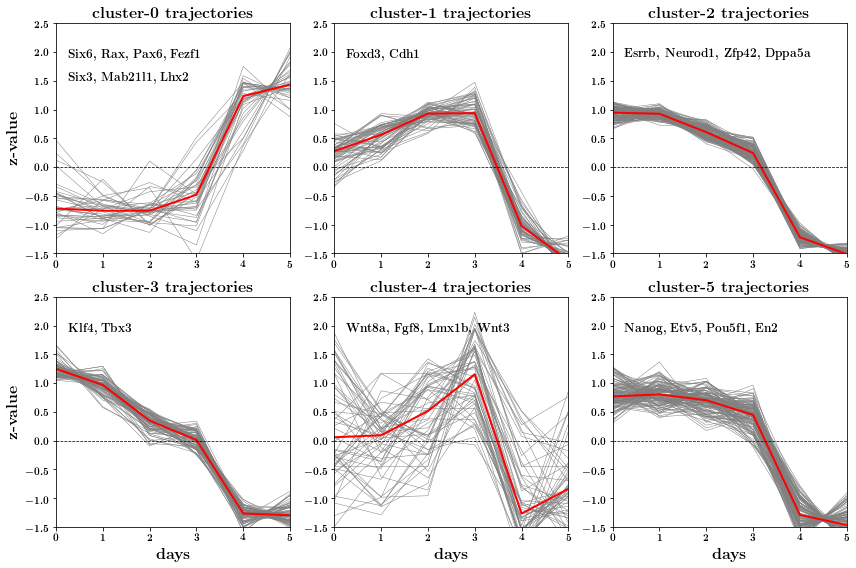

In [17]:
## -------------------------------- ##
## --- gene trajectory clusters --- ##
## -------------------------------- ##

rna_days = [0,1,2,3,4,5]

fig, axs = plt.subplots(2,3,figsize=(12,8))
axs = axs.ravel()
for k, clust_id in enumerate(clust_order):
    
    bool_trajectory_clust = (np.array(ret)==clust_id)
    ## gene trajectories in cluster
    tmp_trajectories = rna_select_expr_zvals[bool_trajectory_clust,:]
    
    ## interesting genes in cluster
    genes_in_clust = [gene for i, gene in enumerate(np.array(rna_select_genes)[bool_trajectory_clust])]
    
    interesting_genes_clust = [gene for gene in genes_in_clust if gene in genes_of_interest]
    
        
    for traj in tmp_trajectories:
        axs[k].plot(rna_days,traj,ls='-',lw=0.5,color='Gray')
    axs[k].plot(rna_days,np.median(tmp_trajectories,axis=0),
                       ls='-',lw=2.0,color='Red')
    axs[k].set_xlim(0,5)
    axs[k].set_ylim(-1.5,2.5)
    #axs[k].grid()
    axs[k].set_title(r'\bf cluster-'+str(k)+' trajectories',fontsize=16)
    if len(interesting_genes_clust) > 4:
        interesting_genes_clust_str1 = ", ".join(interesting_genes_clust[:4])
        interesting_genes_clust_str2 = ", ".join(interesting_genes_clust[4:])
        axs[k].text(0.05,0.85,r'\bf '+interesting_genes_clust_str1,fontsize=12,transform=axs[k].transAxes)
        axs[k].text(0.05,0.75,r'\bf '+interesting_genes_clust_str2,fontsize=12,transform=axs[k].transAxes)
    else:
        interesting_genes_clust_str = ", ".join(interesting_genes_clust)
        axs[k].text(0.05,0.85,r'\bf '+interesting_genes_clust_str,fontsize=12,transform=axs[k].transAxes)
    axs[k].axhline(0,ls='--',lw=0.75,color='Black')
    
axs[0].set_ylabel(r'\bf z-value',fontsize=16)
axs[3].set_ylabel(r'\bf z-value',fontsize=16)
axs[3].set_xlabel(r'\bf days',fontsize=16)
axs[4].set_xlabel(r'\bf days',fontsize=16)
axs[5].set_xlabel(r'\bf days',fontsize=16)

    
plt.tight_layout()
#plt_str = '02_rna-seq-gene-trajectory-clusters-consensus-multiple-seeds.pdf'
#print(plt_str)
#plt.savefig('./figures_paper/'+plt_str,bbox_inches='tight')
plt.show()

In [18]:
file_str = data_dir+'/organoid_gene_clusters_consensus.txt'

#os.remove(file_str)
f1=open(file_str, 'a')

for k, clust_id in enumerate(clust_order):
    
    bool_clust = (np.array(ret) == clust_id)
    genes_in_clust = [gene for i, gene in enumerate(np.array(rna_select_genes)[bool_clust])]
    genes_in_clust = sorted(list(set(genes_in_clust)))
    print(k, sorted(genes_in_clust), len(genes_in_clust))
    genes_in_clust = ", ".join(genes_in_clust)
    f1.write("cluster-"+str(k)+": " + genes_in_clust + "\n")
    
f1.close()

0 ['Arid3c', 'BC064078', 'Edn1', 'Efnb2', 'Ermn', 'Fezf1', 'Foxg1', 'Fzd1', 'Gbx1', 'Gm13584', 'Gm26709', 'Gm27197', 'Grem1', 'Igfbp5', 'Lhx2', 'Lmo3', 'Mab21l1', 'Maf', 'Minar2', 'Necab2', 'Nlgn1', 'Nxph1', 'Pax6', 'Pcdh17', 'Phlda1', 'Ptprz1', 'Rax', 'Raxos1', 'Shisa2', 'Six3', 'Six3os1', 'Six6', 'Slc38a8', 'Slc8a3', 'Tmtc2', 'Vax1', 'Vit'] 37
1 ['2310030G06Rik', 'Ap1m2', 'Bcl11a', 'Bcl11b', 'Bspry', 'Btla', 'Calr4', 'Cass4', 'Cd164l2', 'Cd2', 'Cdcp1', 'Cdh1', 'Clca4a', 'Cldn3', 'Cldn5', 'Cldn6', 'Cldn7', 'Clic5', 'Cnksr1', 'Col14a1', 'Crb3', 'Eomes', 'Epcam', 'Faah', 'Fam83b', 'Fgf5', 'Fgr', 'Foxd3', 'Foxi3', 'Galnt3', 'Gm12688', 'Gstm3', 'H2-Q2', 'Jakmip1', 'Kcng3', 'Lad1', 'Lypd6', 'Lypd6b', 'Mal2', 'Muc3a', 'Ndrg2', 'Pdzk1', 'Pmaip1', 'Ppl', 'Ptgir', 'Rab17', 'Rab25', 'Rasgrp4', 'Rassf6', 'Sec14l4', 'Slc1a3', 'Slc27a2', 'Slc9a3r1', 'Sphkap', 'Timp4', 'Tmem154', 'Tmem184a', 'Tmem30b', 'Tmprss13', 'Tnk1', 'Tns4', 'Trpm6', 'Usp43', 'Vrtn'] 64
2 ['1700097N02Rik', '2410141K09Rik', '49

In [19]:
bool_genes_clusters = []
for k, clust_id in enumerate(clust_order):
    
    bool_clust = (np.array(ret) == clust_id)
    genes_in_clust = [gene for i, gene in enumerate(np.array(rna_select_genes)[bool_clust])]
    tmp_bool = rna_df['ext_gene'].isin(genes_in_clust)
    bool_genes_clusters.append(tmp_bool.tolist())
    
###########################################
## -- save gene clusters to csv file --- ##
###########################################
cluster_names = ['cluster-'+str(i) for i in range(ncpts_best)]
boolean_gene_clusters_df = pd.DataFrame(np.array(bool_genes_clusters).T,columns=cluster_names)

file_str = data_dir+'/organoid_gene_clusters_consensus_boolean.csv'
boolean_gene_clusters_df.to_csv(file_str,sep=',',header=True)